# Using Optimization and Machine Learning with `expsolve`

In [1]:
import time
import numpy as np
import matplotlib.pylab as plt

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, imag, pi
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from IPython import display

In [2]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

# Hamiltonian Identification

### True Hamiltonian

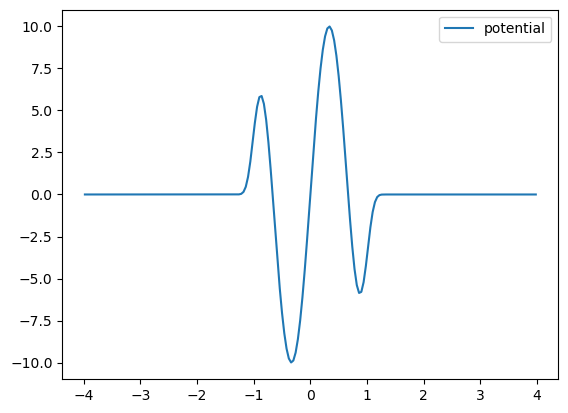

In [3]:
n = 200
L = 4
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)                     # plot versions
V = 10.*exp(-x**8/1)*sin(1.5*pi*x)                  # plot versions

ex.plot(plt, x, V)

plt.legend(['potential'])
plt.show()

### Solvers

In [4]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda V: lambda t, tauL, h, c, u: exp(-1j*c*h*V)*u

strangalpha, strangbeta = split.symmetric([],[])
strangstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, strangalpha, strangbeta)

a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
blanesmoanstep = lambda V: lambda t, h, u0: split.stepper(t, h, u0, eVu(V), eLu, blanesmoanalpha, blanesmoanbeta)

strangsolver = lambda V, u, T, N: es.solvediffeq(u, es.timegrid(T, N), strangstep(V) )[0]
blanesmoansolver = lambda V, u, T, N: es.solvediffeq(u, es.timegrid(T, N), blanesmoanstep(V) )[0]

## Dataset

Randomly generated Gaussian Wave Packets

In [132]:
def ugen(sx0, svar, sw0, loc=0.):
    x0 = np.random.normal(loc=loc, scale=sx0)
    var = 0.1 + np.random.normal(loc=0, scale=svar)**2
    w0 = np.random.normal(loc=0, scale=sw0)

    u = exp(-(x-x0)**2/(2*var))*exp(1j*pi*w0*(x-x0))    
    u = ex.normalize(u, xr)
    return u

In [169]:
# Define your custom dataset class
class GaussianWavefunctions(Dataset):
    def __init__(self, x0, sx0, svar, sw0, T, N, V, solver):
        self.x0 = x0
        self.sx0 = sx0
        self.svar = svar
        self.sw0 = sw0
        self.T = T
        self.N = N
        self.solver = solver
        self.V = V

    def __len__(self):
        return 100000

    def __getitem__(self, index):
        u0 = ugen(self.sx0, self.svar, self.sw0, loc=self.x0)
        uT = self.solver(self.V, u0, self.T, self.N)
        return u0.flatten(), uT.flatten()

dataset = GaussianWavefunctions(x0=0.0, sx0 = 1.0, svar = 0.3, sw0 = 1.5, T = 0.1, N = 20, V=V, solver=strangsolver)
batch_size = 100
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataiterator = iter(dataloader)

In [7]:
u0, uT = next(dataiterator)
u0.shape

torch.Size([100, 200])

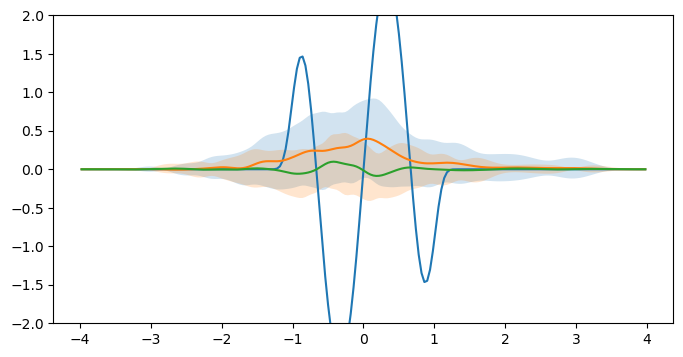

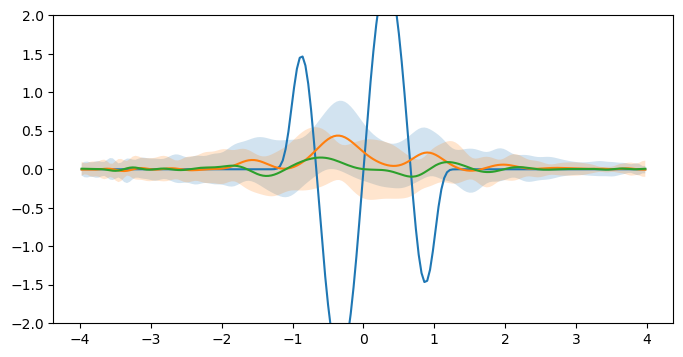

In [8]:
plt.figure(figsize=(8, 4))
plt.ylim(-2,2)
ex.plot(plt, x, V/4)
ex.plotshaded(plt, x, real(u0))
ex.plotshaded(plt, x, imag(u0))
plt.show()


plt.figure(figsize=(8, 4))
plt.ylim(-2,2)
ex.plot(plt, x, V/4)
ex.plotshaded(plt, x, real(uT))
ex.plotshaded(plt, x, imag(uT))
plt.show()

# Neural Network Model

In [9]:
class VNN(nn.Module):

    def __init__(self, x, T, N, solver):
        super(VNN, self).__init__()
        self.T = T
        self.N = N
        self.solver = solver
        
        self.n = x.shape[1]
        self.x = x.flatten().unsqueeze(1)

        self.NN = nn.Sequential(
            nn.Linear(1, 20),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
            )

        self.NN = self.NN.double().to(device)    # double precision

    def _potential(self):
        return self.NN(self.x).reshape([1, self.n])

    # for non-training needs
    def potential(self):
        with torch.no_grad():
            pot = self._potential().cpu()
        return pot

    def forward(self, u0):
        uT = self.solver(self._potential(), u0, self.T, self.N)
        return uT

        
model = VNN(x, T=0.1, N=20, solver=strangsolver)

Checking out the current potential inside the VNN

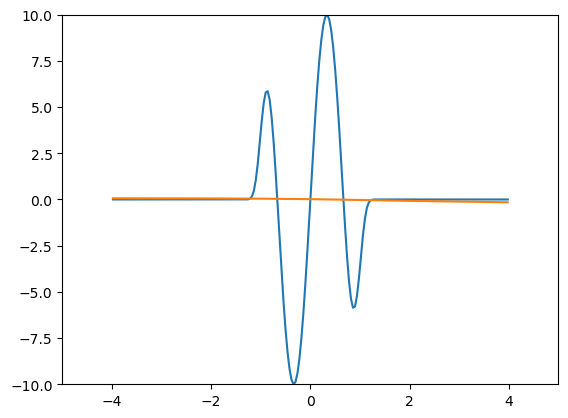

In [10]:
ex.plot(plt, x, V)
ex.plot(plt, x, model.potential())
plt.xlim(-5,5)
plt.ylim(-10,10)

plt.show()

Solving till T under the current potential of the VNN

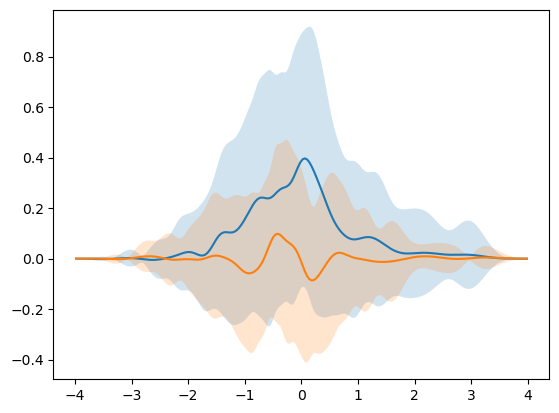

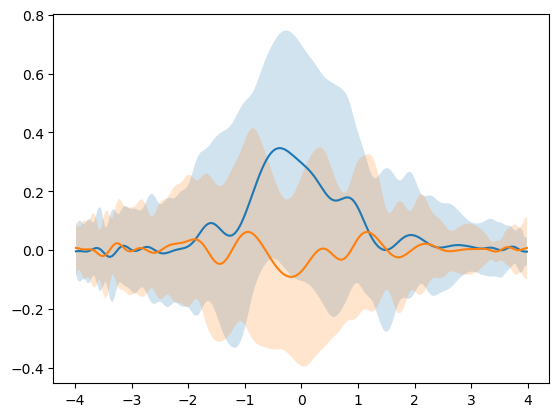

In [11]:
uTmod = model(u0)

ex.plotshaded(plt, x, real(u0))
ex.plotshaded(plt, x, imag(u0))
plt.show()
plt.figure()
ex.plotshaded(plt, x, real(uTmod))
ex.plotshaded(plt, x, imag(uTmod))
plt.show()

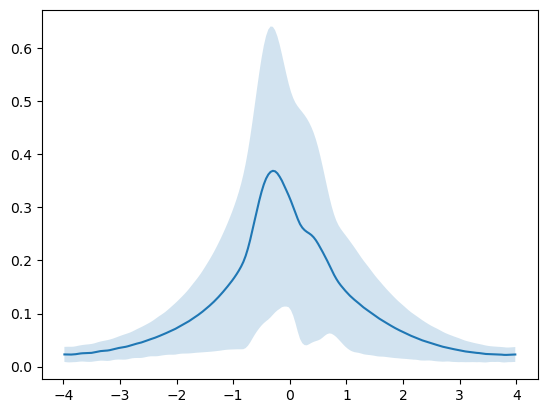

In [12]:
ex.plotshaded(plt, x, abs(strangsolver(V, u0, 0.2, 20)-strangsolver(0*V, u0, 0.2, 20)) )    # what happens when we get V incorrect
plt.show()

### Loss function

Batch loss

In [13]:
u0, uTref = next(dataiterator)
uTmod = model(u0)

dx = x[0,1]-x[0,0]
criterion = nn.MSELoss()
loss = n * dx * (criterion(real(uTmod), real(uTref)) + criterion(imag(uTmod), imag(uTref)))
loss

tensor(0.1025, dtype=torch.float64, grad_fn=<MulBackward0>)

Looped loss function

In [14]:
def looplossfn(V, u0batch, uTbatch, solver, T, N):
    dx = x[0,1]-x[0,0]
    nbatch = u0batch.shape[0]

    loss = torch.tensor(0., dtype=torch.float64).to(device)

    for u0, uTref in zip(u0batch, uTbatch):
        uT = solver(V, u0, T, N)
        loss += torch.norm(uT - uTref)**2
    
    loss = dx * loss/nbatch
    return loss

looplossfn(model._potential(), u0, uTref, solver=strangsolver, T=0.1, N=20)

tensor(0.1025, dtype=torch.float64, grad_fn=<DivBackward0>)

### Comparison between Batch and Looped loss

In [15]:
tim1 = time.time()
loss1 = n * dx * (criterion(real(uTmod), real(uTref)) + criterion(imag(uTmod), imag(uTref)))
tim2 = time.time()
tim_batch = tim2-tim1
print(f'Batch of size {batch_size} took {tim_batch}s')
print(f'Batch Loss: {loss1}')

tim1 = time.time()
loss2 = looplossfn(model._potential(), u0, uTref, solver=strangsolver, T=0.1, N=20)
tim2 = time.time()
tim_loop = tim2-tim1
print(f'Loop of size {batch_size} took {tim_loop}s')
print(f'Loop Loss: {loss2}')

print(f'Speed up factor {tim_loop/tim_batch:.2f} on {device}')

print(f'Difference in losses: {torch.abs(loss2-loss1)}')

Batch of size 100 took 0.0019989013671875s
Batch Loss: 0.1025268800184554
Loop of size 100 took 1.6300175189971924s
Loop Loss: 0.10252688001845536
Speed up factor 815.46 on cpu
Difference in losses: 4.163336342344337e-17


At step 299, loss is 0.00029352221347387573


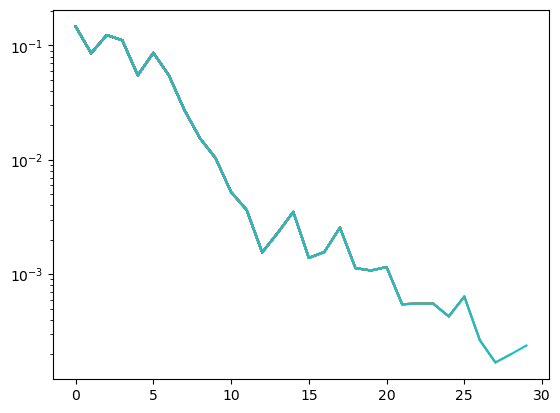

In [17]:
%matplotlib inline

# Create an instance of the SimpleNN model
model = VNN(x, T=0.1, N=20, solver=strangsolver).to(device)
nn.DataParallel(model).to(device)

nbatch = 10
dataloader = DataLoader(dataset, batch_size=nbatch, shuffle=True)
dataiterator = iter(dataloader)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 300

trerror = []


dx = x[0,1]-x[0,0]
criterion = nn.MSELoss()

for step in range(num_steps):
    # Compute the loss
    u0, uTref = next(dataiterator)
    uTmod = model(u0)
    
    tim1 = time.time()
    loss = n * dx * (criterion(real(uTmod), real(uTref)) + criterion(imag(uTmod), imag(uTref)))
    tim2 = time.time()
    tim_batch = tim2-tim1
    #print(f'Loss {loss} computed with batch of size {nbatch} in {tim_batch:e}s')

    optimizer.zero_grad()

    # Compute gradients
    tim1 = time.time()
    loss.backward()
    tim2 = time.time()
    tim_backward = tim2-tim1
    #print(f'Backprop computed in {tim_backward:e}s')


    if np.mod(step, 10)==0:
        trerror.append(loss.detach().cpu().numpy())        
        plt.semilogy(trerror)
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Update parameters using the gradients
    tim1 = time.time()
    optimizer.step()
    tim2 = time.time()
    tim_opt = tim2-tim1
    #print(f'Optimizer step taken in {tim_opt:e}s')


print(f'At step {step}, loss is {loss}')

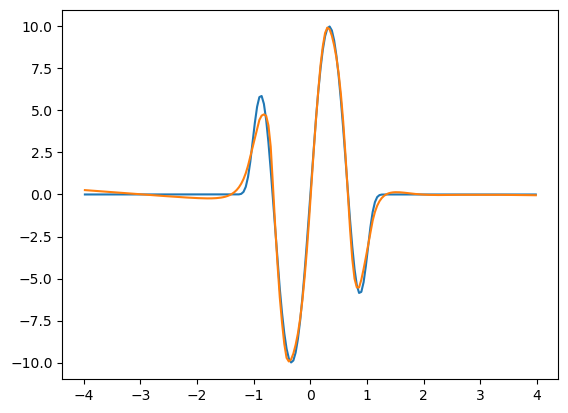

In [18]:
ex.plot(plt, x, V)
ex.plot(plt, x, model.potential())
plt.show()

# Optimal Control

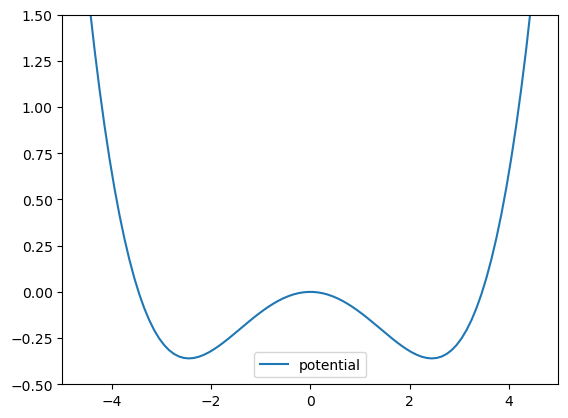

In [324]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr).to(device)                    
V = x**4 - 12.*x**2                 

T = 1.

ex.plot(plt, x, V/100)
plt.ylim([-0.5,1.5])
plt.xlim([-5,5])
plt.legend(['potential'])
plt.show()

In [363]:
observables = {'energy': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u: ex.observable(lambda psi: V*psi, u, xr)}

In [365]:
dataset = GaussianWavefunctions(x0=-2.75, sx0 = 0.2, svar = 0.2, sw0 = 1., T = T, N = 100, V=V, solver=strangsolver)
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataiterator = iter(dataloader)

In [366]:
u0, uT = next(dataiterator)
observables['energy'](u0)

tensor([-5.3758], dtype=torch.float64)

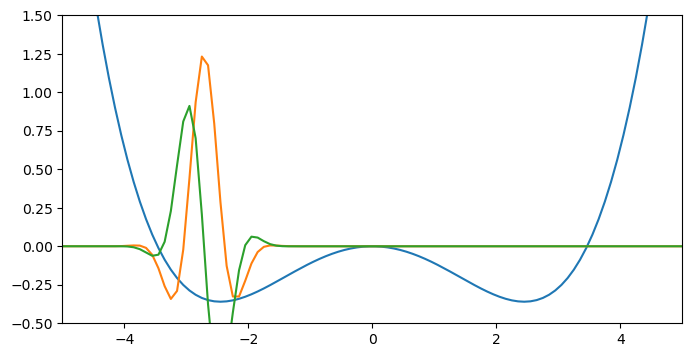

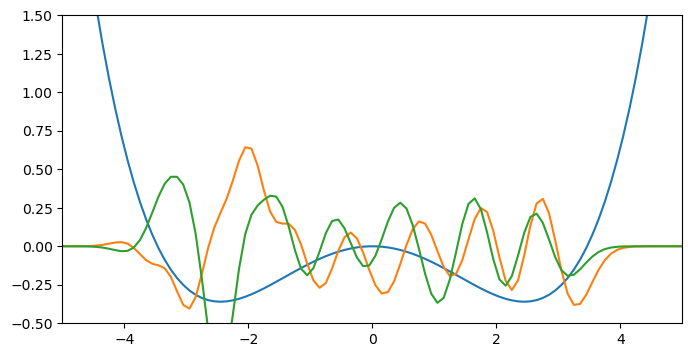

In [367]:
plt.figure(figsize=(8, 4))
plt.ylim([-0.5,1.5])
plt.xlim([-5,5])
ex.plot(plt, x, V/100)
ex.plotshaded(plt, x, real(u0))
ex.plotshaded(plt, x, imag(u0))
plt.show()


plt.figure(figsize=(8, 4))
plt.ylim([-0.5,1.5])
plt.xlim([-5,5])
ex.plot(plt, x, V/100)
ex.plotshaded(plt, x, real(uT))
ex.plotshaded(plt, x, imag(uT))
plt.show()

In [368]:
N = 100
timegrid = es.timegrid(T=T, N=N)
timegrid

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000], dtype=torch.float64)

In [369]:
eLu = lambda t, tauV, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVtu = lambda e: lambda t, tauL, h, c, u: exp(-1j*c*h*(V+e(t+tauL)*x))*u

strangstep_Vt = lambda e: lambda t, h, u0: split.stepper(t, h, u0, eVtu(e), eLu, strangalpha, strangbeta)

In [410]:
class VNNcontrol(nn.Module):

    def __init__(self, x):
        super(VNNcontrol, self).__init__()
        self.T = T
        self.N = N
        
        self.n = x.shape[1]
        self.x = x.flatten().unsqueeze(1)

        self.NN = nn.Sequential(
            nn.Linear(1, 20),   # Fully connected layer 1 with 1 input and 32 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 20),  # Fully connected layer 2 with 32 input neurons and 16 output neurons
            nn.ELU(),          # ReLU activation function
            nn.Linear(20, 1)    # Fully connected layer 3 with 16 input neurons and 1 output neuron
            )

        self.NN = self.NN.double().to(device)    # double precision

    def _e(self, t):
        return 1e1*self.NN(torch.tensor([t], dtype=torch.float64))[0]

    def pulse(self):
        return 1e1*model.NN(timegrid.unsqueeze(dim=1))

    def pulseenergy(self):
        return (timegrid[1]-timegrid[0]) * torch.norm(self.pulse())**2

    # for non-training needs
    def e(self):
        with torch.no_grad():
            return self.pulse().cpu()

    def forward(self, u0):
        uT = es.solvediffeq(u0, timegrid, strangstep_Vt(lambda t: self._e(t)) )[0]
        return uT

        
model = VNNcontrol(x)

In [411]:
model.pulseenergy()

tensor(0.2796, dtype=torch.float64, grad_fn=<MulBackward0>)

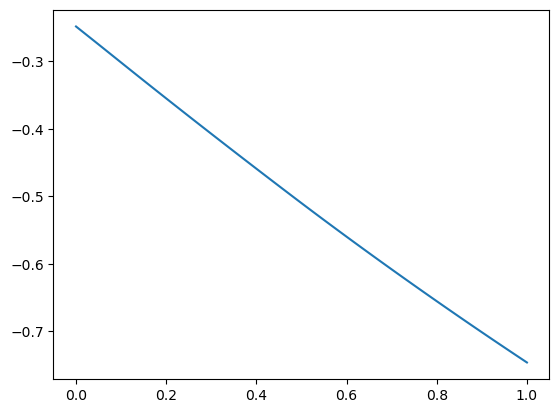

In [412]:
plt.plot(timegrid, model.e())
plt.show()

In [413]:
uTinit = model(u0)
observables['energy'](uTinit)

tensor([-4.4264], dtype=torch.float64, grad_fn=<SelectBackward0>)

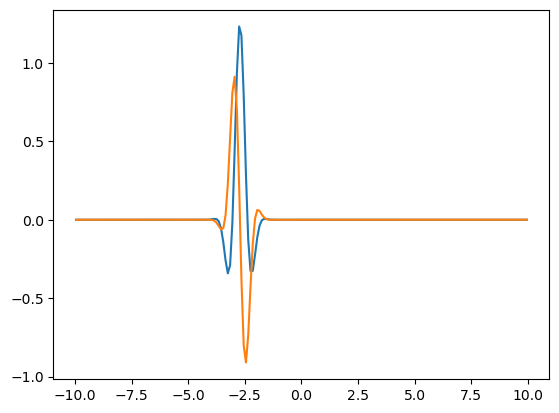

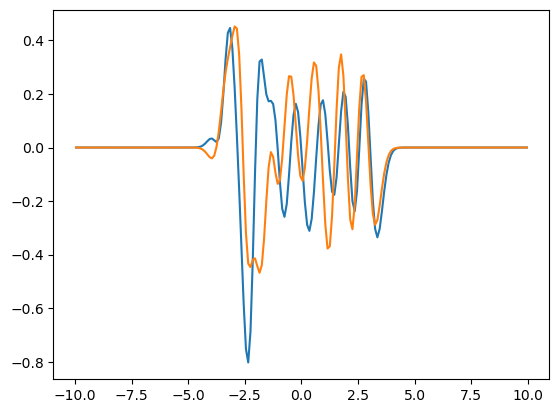

In [414]:
ex.plotshaded(plt, x, real(u0))
ex.plotshaded(plt, x, imag(u0))
plt.show()
plt.figure()
ex.plotshaded(plt, x, real(uTinit))
ex.plotshaded(plt, x, imag(uTinit))
plt.show()

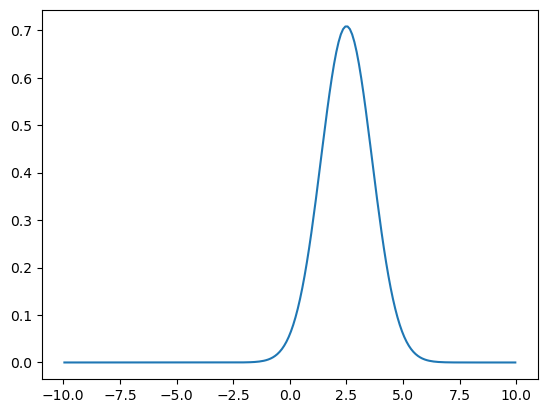

In [439]:
utarget = ugen(0.0, 1.0, 0.0, loc=2.5)
ex.plot(plt, x, real(utarget))

In [440]:
utarget = utarget.repeat([u0.shape[0], 1])

In [441]:
ex.l2norm(utarget-uTmod, xr)

tensor([1.4142], dtype=torch.float64, grad_fn=<MulBackward0>)

In [442]:
torch.tensor(1.)-torch.abs(ex.l2inner(uTmod, utarget, xr)[0])**2
loss

tensor(1.0000, dtype=torch.float64, grad_fn=<SubBackward0>)

In [443]:
dx = x[0,1]-x[0,0]
criterion = nn.MSELoss()
loss = n * dx * (criterion(real(uTmod), real(utarget)) + criterion(imag(uTmod), imag(utarget))) # + 1e-3 * model.pulseenergy()
loss
    

tensor(2.0000, dtype=torch.float64, grad_fn=<MulBackward0>)

At step 299, loss is 0.24592371955259673


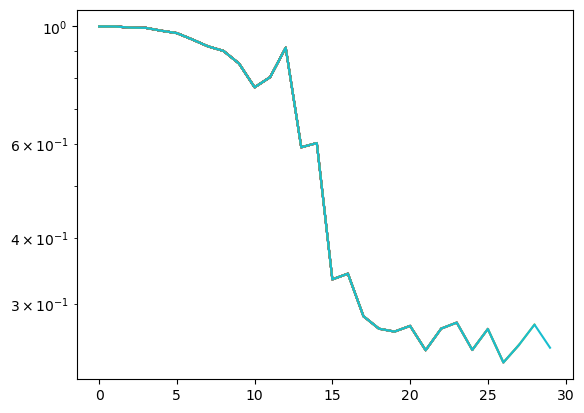

In [449]:
%matplotlib inline

# Create an instance of the SimpleNN model
#model = VNNcontrol(x)
#nn.DataParallel(model).to(device)

#nbatch = 10
#dataloader = DataLoader(dataset, batch_size=nbatch, shuffle=True)
#dataiterator = iter(dataloader)

#utarget = ugen(0.0, 0.0, 0.0, loc=2.5)
#utarget = utarget.repeat([nbatch, 1])

optimizer = torch.optim.Adam(model.parameters(), lr=0.01) #, dtype=torch.double)
num_steps = 300

trerror = []


dx = x[0,1]-x[0,0]
criterion = nn.MSELoss()

for step in range(num_steps):
    # Compute the loss
    #u0, _ = next(dataiterator)
    uTmod = model(u0)
    
    tim1 = time.time()
    #loss = n * dx * (criterion(real(uTmod), real(utarget)) + criterion(imag(uTmod), imag(utarget))) # +  1e-3 * model.pulseenergy()
    #loss = observables['energy'](uTmod)[0]
    loss = torch.tensor(1.)-torch.abs(ex.l2inner(uTmod, utarget, xr)[0])**2
    tim2 = time.time()
    tim_batch = tim2-tim1
    #print(f'Loss {loss} computed with batch of size {nbatch} in {tim_batch:e}s')

    optimizer.zero_grad()

    # Compute gradients
    tim1 = time.time()
    loss.backward()
    tim2 = time.time()
    tim_backward = tim2-tim1
    #print(f'Backprop computed in {tim_backward:e}s')


    if np.mod(step, 10)==0:
        trerror.append(loss.detach().cpu().numpy())        
        plt.semilogy(trerror)
        display.display(plt.gcf())
        display.clear_output(wait=True)

    # Update parameters using the gradients
    tim1 = time.time()
    optimizer.step()
    tim2 = time.time()
    tim_opt = tim2-tim1
    #print(f'Optimizer step taken in {tim_opt:e}s')


print(f'At step {step}, loss is {loss}')

In [450]:
torch.tensor(1.)-torch.abs(ex.l2inner(uTmod, utarget, xr)[0])**2

tensor(0.2459, dtype=torch.float64, grad_fn=<SubBackward0>)

In [453]:
T

1.0

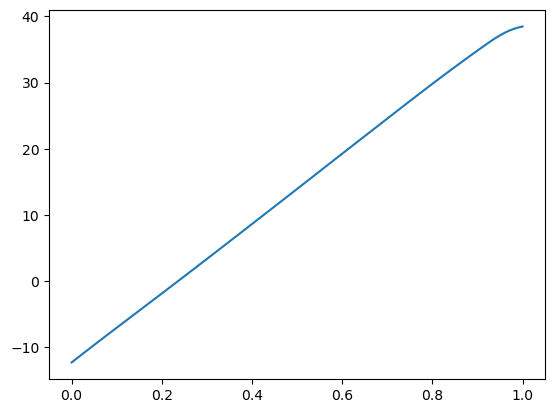

In [451]:
plt.plot(timegrid, model.e())
plt.show()

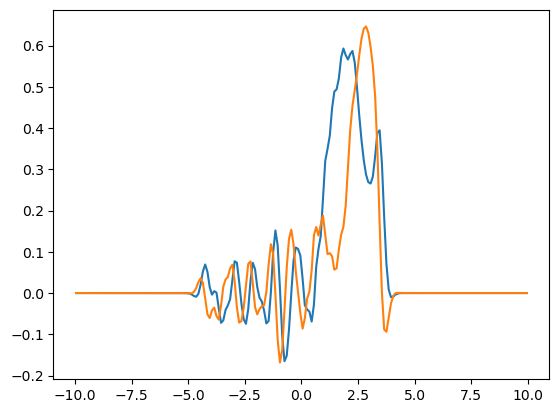

In [452]:
plt.figure()
ex.plotshaded(plt, x, real(uTmod))
ex.plotshaded(plt, x, imag(uTmod))
plt.show()

In [424]:
observables['energy'](uTmod)

tensor([-30.9635], dtype=torch.float64, grad_fn=<SelectBackward0>)

In [403]:
observables['energy'](uTinit)

tensor([-3.6815], dtype=torch.float64, grad_fn=<SelectBackward0>)